<a id='summary'></a>

## Summary

### [1. Dataset](#dataset)

### [2. Multiclass classification](#multiclass_classification)

### [3. Neural Network Models](#nn_models)

### [4. Results](#results)

### [5. Save/Load the model](#save)

### [6. Read a handwritten digit image PNG and make a prediction](#read)

### [7. Next steps](#next_steps)

### [References](#refs)

# MULTIPLE CLASS CLASSIFIER

In [1]:
import os
import time
import struct
import gzip

import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load

from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score

init_time_global = time.time()

<a id='dataset'></a>

## [^](#summary) 1. Dataset

The version of the MNIST (Modified National Institute of Standards and Technology) database used here is a database of handwritten digits that has a training set of 60000 image samples and a test set of 10000.

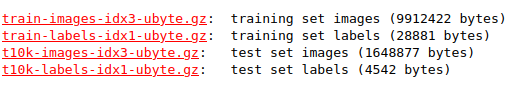


**Dowload**: http://yann.lecun.com/exdb/mnist/

In [2]:
# after download
os.listdir(r'./datasets/mnist_784/compressed/')

['train-images-idx3-ubyte.gz',
 't10k-images-idx3-ubyte.gz',
 't10k-labels-idx1-ubyte.gz',
 'train-labels-idx1-ubyte.gz']

### Auxiliary functions

In [3]:
def load_dataset(path_dataset):
    with gzip.open(path_dataset,'rb') as f:
        magic, size = struct.unpack('>II', f.read(8))
        nrows, ncols = struct.unpack('>II', f.read(8))
        data = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, nrows, ncols))
        return data

In [4]:
def load_label(path_label):
     with gzip.open(path_label,'rb') as f:
        magic, size = struct.unpack('>II', f.read(8))
        data = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))        
        return data

### Load datasets

In [5]:
X_train = load_dataset(r'./datasets/mnist_784/compressed/train-images-idx3-ubyte.gz')
y_train = load_label(r'./datasets/mnist_784/compressed/train-labels-idx1-ubyte.gz')

X_test = load_dataset(r'./datasets/mnist_784/compressed/t10k-images-idx3-ubyte.gz')
y_test = load_label(r'./datasets/mnist_784/compressed/t10k-labels-idx1-ubyte.gz')

In [6]:
print('Dimensions:')

print(f'\nX_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')

print(f'\nX_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

Dimensions:

X_train.shape = (60000, 28, 28)
y_train.shape = (60000,)

X_test.shape = (10000, 28, 28)
y_test.shape = (10000,)


## Histogram of labels

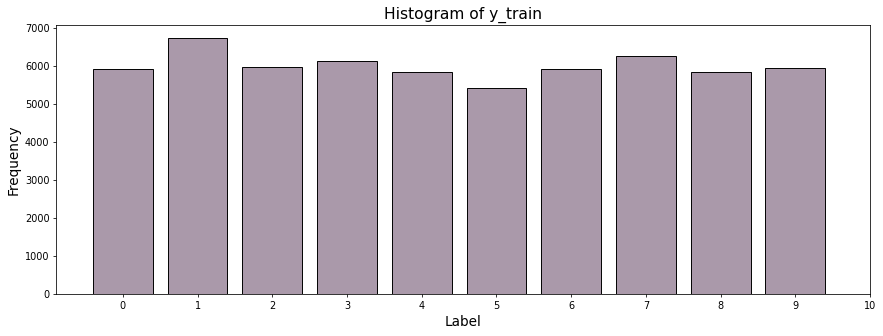

In [7]:
fig, axs = plt.subplots(figsize=(15, 5), dpi=70)
x_ticks = np.arange(min(y_train), max(y_train)+2, 1)
bins = x_ticks - 0.5
plt.hist(y_train, edgecolor='k', rwidth=0.8, bins=bins, color='#AA99AA')
plt.title('Histogram of y_train', size=16)
plt.xlabel('Label', size=14)
plt.ylabel('Frequency', size=14)
plt.xticks(x_ticks)
plt.show()

## Looking at some samples

### One sample

In [8]:
X_train[7,:,:][10:15]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  85, 243, 252, 252, 144,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  88, 189, 252, 252, 252,  14,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  91, 212, 247, 252, 252, 252, 204,   9,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  32, 125, 193, 193,
        193, 253, 252, 252, 252, 238, 102,  28,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  45, 222, 252, 252, 252,
        252, 253, 252, 252, 252, 177,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=uint8)

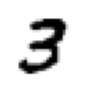

In [9]:
fig, axs = plt.subplots(figsize=(2, 2), dpi=50)
plt.imshow(X_train[7,:,:], cmap='binary')
plt.axis('off')
plt.show()

### Matrix of samples

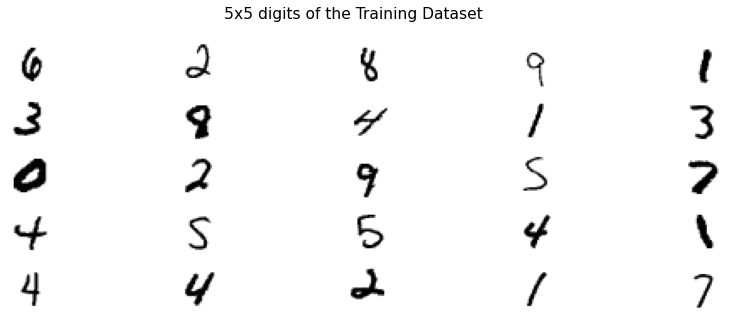

In [10]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 5), dpi=70)
for idx, ax in enumerate(axs.ravel()):    
    ax.imshow(X_train[np.random.randint(0,len(X_train))].reshape(28, 28), cmap='binary')
    ax.axis('off')
    fig.suptitle('5x5 digits of the Training Dataset', fontsize=16)

### A random sample

In [11]:
idx_random = np.random.randint(0,len(X_train))
print(f'idx_random = {idx_random}')

some_digit = X_train[idx_random]

idx_random = 36781


In [12]:
my_dpi = 30

fig, axs = plt.subplots(figsize=(29/my_dpi, 29/my_dpi), dpi=my_dpi)
plt.imshow(some_digit, cmap='binary')
plt.axis('off')
plt.show()

In [13]:
print(some_digit.shape)

some_digit[10:13]

(28, 28)


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11,
        112,  34,   0,   0,   0, 249, 157,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  72, 252, 106,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,  60,
         60,  46,   0,   0, 140, 253, 106,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=uint8)

**Note:** shape = 28x28 => 724 pixels

<a id='multiclass_classification'></a>


## [^](#summary) 2. Multiclass classification

In [14]:
X_train.shape

(60000, 28, 28)

In [15]:
y_train.shape

(60000,)

### Model SGDClassifier

`Stochastic Gradient Descent (SGD) Classifier` is a simple but very efficient approach to fitting linear classifiers under convex loss functions (e.g., Logistic Regression). It has a good performance for large-scale learning.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [17]:
model_sgd_classifier = make_pipeline(StandardScaler(),
                                     SGDClassifier(random_state=42))

In [18]:
init_time = time.time()

model_sgd_classifier.fit((X_train).reshape(len(X_train), 28*28), y_train)

print(f'Elapsed time: {time.time() - init_time:.2f} s')

Elapsed time: 229.40 s


In [19]:
model_sgd_classifier.predict([(some_digit).reshape(28*28)])

array([2], dtype=uint8)

**Question:** Is the predicted value equal to or different from the randomly chosen value?

In [20]:
model_sgd_classifier.score((X_test).reshape(len(X_test), 28*28), y_test)

0.8933

### Model SGDClassifier (with probability estimation)

**Note**: For predicting probability we can use `loss='log_loss'` or `loss='modified_huber'`.

In [21]:
# to add probablities
model_sgd_prob_classifier = SGDClassifier(random_state=42, loss='log_loss', 
                                           alpha=1e-3, class_weight='balanced')

In [22]:
init_time = time.time()

model_sgd_prob_classifier.fit((X_train/255).reshape(len(X_train), 28*28), y_train)

print(f'Elapsed time: {time.time() - init_time:.2f} s')

Elapsed time: 8.89 s


In [23]:
model_sgd_prob_classifier.predict([(some_digit).reshape(28*28)])

array([2], dtype=uint8)

In [24]:
model_sgd_prob_classifier.predict_proba([(some_digit).reshape(28*28)])

array([[2.24951769e-92, 0.00000000e+00, 5.00000000e-01, 5.00000000e-01,
        0.00000000e+00, 0.00000000e+00, 5.54565586e-46, 0.00000000e+00,
        8.59815555e-98, 0.00000000e+00]])

In [25]:
model_sgd_prob_classifier.score((X_test/255).reshape(len(X_test), 28*28), y_test)

0.9132

### Model Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
model_rf = RandomForestClassifier(max_depth=16, random_state=42)

In [28]:
init_time = time.time()

model_rf.fit((X_train/255).reshape(len(X_train), 28*28), y_train)

print(f'Elapsed time: {time.time() - init_time:.2f} s')

Elapsed time: 20.21 s


In [29]:
model_rf.predict([(some_digit).reshape(28*28)])

array([2], dtype=uint8)

In [30]:
model_rf.score((X_test/255).reshape(len(X_test), 28*28), y_test)

0.9676

### OneVsOneClassifier

In [31]:
model_ovo_classifier = OneVsOneClassifier(SGDClassifier(random_state=42, n_jobs=-1))

In [32]:
init_time = time.time()

model_ovo_classifier.fit((X_train/255).reshape(len(X_train), 28*28), y_train)

print(f'Elapsed time: {time.time() - init_time} s')

Elapsed time: 16.457059860229492 s


In [33]:
model_ovo_classifier.predict([(some_digit/255).reshape(28*28)])

array([2], dtype=uint8)

In [34]:
model_ovo_classifier.score((X_test/255).reshape(len(X_test), 28*28), y_test)

0.9315

In [35]:
# %whos

<a id='nn_models'></a>


## [^](#summary) 3. Neural Network Models

### Model MLP Classifier

`MLPClassifier` implements a multi-layer perceptron (MLP) algorithm.

In [36]:
from sklearn.neural_network import MLPClassifier

In [37]:
model_mlp = MLPClassifier(random_state=42, max_iter=300)

In [38]:
init_time = time.time()

model_mlp.fit((X_train/255).reshape(len(X_train), 28*28), y_train)

print(f'Elapsed time: {time.time() - init_time} s')

Elapsed time: 42.81110858917236 s


In [39]:
model_mlp.predict([(some_digit).reshape(28*28)])

array([2], dtype=uint8)

In [40]:
model_mlp.score((X_test/255).reshape(len(X_test), 28*28), y_test)

0.9782

<a id='results'></a>


## [^](#summary) 4. Results


|     Model                         | Score (X_test)     |  ~Time (s)        | Variable                   |
|-----------------------------------|:------------------:|------------------:|:--------------------------:|
|SGD Classifier                     |   0.8933           |   229.41          | model_sgd_classifier       |
|SGD Classifier (loss='log_loss')   |   0.9132           |   8.83            | model_sgd_prob_classifier  |
|Random Forest Classifier           |   0.9676           |   20.16           | model_rf                   |
|One Vs One Classifier              |   0.9315           |   16.44           | model_ovo_classifier       |
|Multilayer Perceptron Classifier   |   0.9782           |   40.98           |  model_mlp                 |
|[EnsNet](https://paperswithcode.com/paper/ensemble-learning-in-cnn-augmented-with-fully#code)|0.9984| ? | [see paper](https://arxiv.org/pdf/2003.08562v3.pdf)|



### Make a cross-validation

#### 1st model: Multilayer Perceptron

In [41]:
init_time = time.time()

print(cross_val_score(model_mlp, (X_train/255).reshape(len(X_train), 28*28), y_train, 
                      cv=3, scoring='accuracy', n_jobs=-1))

print(f'Elapsed time: {time.time() - init_time} s')

[0.9732  0.9717  0.97185]
Elapsed time: 38.134296894073486 s


#### 2nd model: Random Forest

In [42]:
# init_time = time.time()

print(cross_val_score(model_rf, (X_train/255).reshape(len(X_train), 28*28), y_train,
                      cv=3, scoring='accuracy', n_jobs=-1))

print(f'Elapsed time: {time.time() - init_time} s')

[0.9628  0.9609  0.96355]
Elapsed time: 54.98952555656433 s


<a id='save'></a>


## [^](#summary) 5. Save/Load the model

### Using Pickle

In [43]:
import pickle

output = open('model_classifier_mnist.pkl', 'wb')

pickle.dump(model_mlp, output, -1)

output.close()

In [44]:
pickle_file = open('model_classifier_mnist.pkl', 'rb')

model_test = pickle.load(pickle_file)

pickle_file.close()

In [45]:
model_test

MLPClassifier(max_iter=300, random_state=42)

In [46]:
model_test.predict([(some_digit/255).reshape(28*28)])

array([2], dtype=uint8)

### Using Joblib

In [47]:
dump(model_rf, 'model_classifier_mnist.joblib')

['model_classifier_mnist.joblib']

In [48]:
model_test_joblib = load('model_classifier_mnist.joblib')

In [49]:
model_test_joblib

RandomForestClassifier(max_depth=16, random_state=42)

In [50]:
help(model_test_joblib.predict)

Help on method predict in module sklearn.ensemble._forest:

predict(X) method of sklearn.ensemble._forest.RandomForestClassifier instance
    Predict class for X.
    
    The predicted class of an input sample is a vote by the trees in
    the forest, weighted by their probability estimates. That is,
    the predicted class is the one with highest mean probability
    estimate across the trees.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The input samples. Internally, its dtype will be converted to
        ``dtype=np.float32``. If a sparse matrix is provided, it will be
        converted into a sparse ``csr_matrix``.
    
    Returns
    -------
    y : ndarray of shape (n_samples,) or (n_samples, n_outputs)
        The predicted classes.



#### Make a test

In [51]:
idx_random = np.random.randint(0,len(X_train))
print(f'idx_random = {idx_random}')

some_digit = X_train[idx_random]

idx_random = 30014


In [52]:
my_dpi = 30

fig, axs = plt.subplots(figsize=(29/my_dpi, 29/my_dpi), dpi=my_dpi)
plt.imshow(some_digit, cmap='binary')
plt.axis('off')
plt.show()

In [53]:
model_test

MLPClassifier(max_iter=300, random_state=42)

In [54]:
model_test.predict([some_digit.reshape(28*28)])

array([2], dtype=uint8)

In [55]:
model_test_joblib

RandomForestClassifier(max_depth=16, random_state=42)

In [56]:
model_test_joblib.predict([some_digit.reshape(28*28)])

array([2], dtype=uint8)

<a id='read'> </a>

## [^](#summary) 6. Read a handwritten digit image PNG and make a prediction

In [57]:
from PIL import Image

import cv2

In [58]:
PATH_IMG = r'./imgs'

In [59]:
l = 1
file_name = os.path.join(PATH_IMG, f'digit_{l}.png')

**Note:**

- 1, 2, 4, 5, 8, 9 => ok

- 3, 6 => ok?

In [60]:
img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
# img = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)

In [61]:
img.shape

(28, 28)

In [62]:
img[10:12]

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0, 255, 255,
        255,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255]], dtype=uint8)

In [63]:
img = cv2.bitwise_not(img)
img[10:12]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,   0,   0,
          0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=uint8)

In [64]:
blur_image = cv2.GaussianBlur(img, (3, 3), 0)

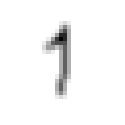

In [65]:
fig, axs = plt.subplots(figsize=(3, 3), dpi=50)
plt.imshow(blur_image, cmap='binary')
plt.axis('off')
plt.show()

In [66]:
model_mlp.predict([(blur_image/255).reshape(28*28)])

array([1], dtype=uint8)

In [67]:
model_sgd_prob_classifier.predict([(blur_image/255).reshape(28*28)])

array([1], dtype=uint8)

In [68]:
model_sgd_prob_classifier.predict_proba([(blur_image/255).reshape(28*28)])

array([[2.74161359e-05, 6.43333817e-01, 2.43334704e-02, 4.57142610e-03,
        1.82776712e-03, 1.63575371e-01, 4.16589805e-03, 1.14029596e-01,
        4.89274472e-04, 4.36459634e-02]])

In [69]:
model_rf.predict([(blur_image/255).reshape(28*28)])

array([1], dtype=uint8)

In [70]:
model_rf.predict_proba([(blur_image/255).reshape(28*28)])

array([[0.0028373 , 0.35321106, 0.07411634, 0.04624998, 0.06242589,
        0.07556958, 0.03322564, 0.17098307, 0.13025777, 0.05112338]])

In [71]:
np.sort(model_mlp.predict_proba([(blur_image/255).reshape(28*28)]))[0][-1]*100

99.62925107932416

In [72]:
model_mlp

MLPClassifier(max_iter=300, random_state=42)

In [73]:
fig, axs = plt.subplots(figsize=(28, 28), dpi=1)
plt.imshow(img, cmap='binary')
plt.axis('off')
plt.show()

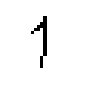

In [74]:
fig, axs = plt.subplots(figsize=(28, 28), dpi=4) # dpi=1)
plt.imshow(img, cmap='binary')
plt.axis('off')
plt.show()

<a id='next_steps'></a>

## [^](#summary) 7. Next steps


- https://paperswithcode.com/sota/image-classification-on-mnist

<a id='refs'></a>

## [^](#summary) References

http://yann.lecun.com/exdb/mnist/
    
https://stackoverflow.com/questions/39969045/parsing-yann-lecuns-mnist-idx-file-format

https://stackoverflow.com/questions/50280640/open-load-image-as-numpy-ndarray-directly

https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels

https://paperswithcode.com/sota/image-classification-on-mnist

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

https://stackoverflow.com/questions/7624765/converting-an-opencv-image-to-black-and-white

In [75]:
# print(f'>>> Elapsed time: {time.time() - init_time_global}')